In [ ]:
! pip install meteostat

Fetching historical data...
Training the Random Forest model...
Making predictions...
Root Mean Squared Error (RMSE): 2.63


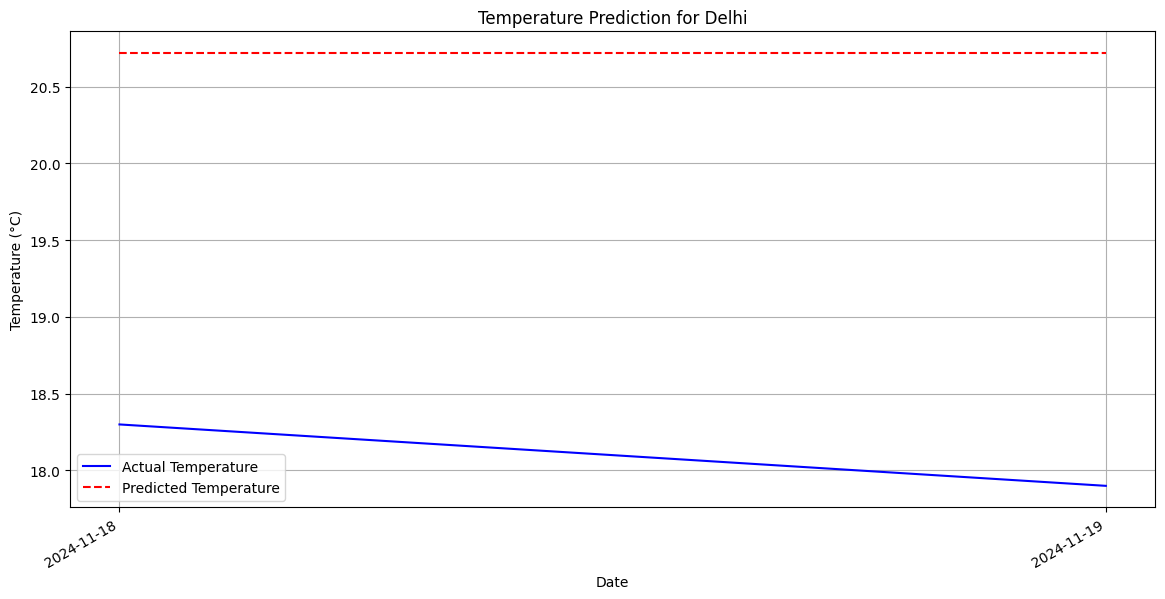

Predicted temperature for 2024-11-20: 20.72 °C


In [13]:


import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from meteostat import Daily, Stations
import matplotlib.dates as mdates

# Define the location (Delhi)
CITY = "Delhi"

# Coordinates for Delhi
latitude = 28.6139
longitude = 77.2090

# Get stations near Delhi
stations = Stations()
stations = stations.nearby(latitude, longitude)

# Fetch the nearest station
station = stations.fetch(1)

if station.empty:
    print("No station found for the specified city.")
else:
    # Define date range for the past 6 months
    end_date = datetime(2024, 11, 19)
    start_date = end_date - timedelta(days=180)

    # Fetch data for the last 6 months
    print("Fetching historical data...")
    data = Daily(station.index[0], start_date, end_date)
    data = data.fetch()
    # Ensure data is not empty
    if data.empty:
        print("No data available for the specified date range.")
    else:
        # 2. Preprocess data
        data = data[['tavg']].rename(columns={'tavg': 'Temperature'})
        data.index.name = 'Date'
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # 3. Handle missing values
        # FIX: Assign the interpolated values back to the DataFrame without inplace
        data['Temperature'] = data['Temperature'].interpolate(method='time')

        # 4. Prepare features
        def prepare_features(data, lag_days=7):
            """
            Create lag features for the dataset.
            """
            df = data.copy()
            for lag in range(1, lag_days + 1):
                df[f'Temperature_Lag_{lag}'] = df['Temperature'].shift(lag)
            df.dropna(inplace=True)
            return df

        # Use a 7-day lag for prediction
        data_prepared = prepare_features(data, lag_days=7)

        # 5. Split data into training and testing sets
        train_end_date = datetime(2024, 11, 18)
        train_data = data_prepared[data_prepared.index < train_end_date]
        test_data = data_prepared[data_prepared.index >= train_end_date]

        X_train = train_data.drop(columns=['Temperature'])
        y_train = train_data['Temperature']
        X_test = test_data.drop(columns=['Temperature'])
        y_test = test_data['Temperature']

        # Check if training and testing data are not empty
        if X_train.empty or X_test.empty:
            print("Error: Training or testing data is empty. Please check the data fetching and preprocessing steps.")
        else:
            # 6. Train a Random Forest model
            print("Training the Random Forest model...")
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            # 7. Predict the temperature for the test set
            print("Making predictions...")
            y_pred = model.predict(X_test)

            # 8. Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

            # 9. Visualize results
            plt.figure(figsize=(14, 7))
            plt.plot(test_data.index, y_test, label="Actual Temperature", color='blue', linestyle='-')
            plt.plot(test_data.index, y_pred, label="Predicted Temperature", color='red', linestyle='--')
            plt.title(f"Temperature Prediction for {CITY}")
            plt.xlabel("Date")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
            plt.gcf().autofmt_xdate()
            plt.show()

            # Predict the temperature for the next day (2024-11-20)
            # FIX: Ensure input has feature names by keeping it as a DataFrame
            last_known_data = data_prepared.drop(columns=['Temperature']).iloc[-1:].copy()
            next_day_prediction = model.predict(last_known_data)
            print(f"Predicted temperature for 2024-11-20: {next_day_prediction[0]:.2f} °C")

Fetching historical hourly data...
Training the Random Forest model...


Making predictions...
Root Mean Squared Error (RMSE): 2.11


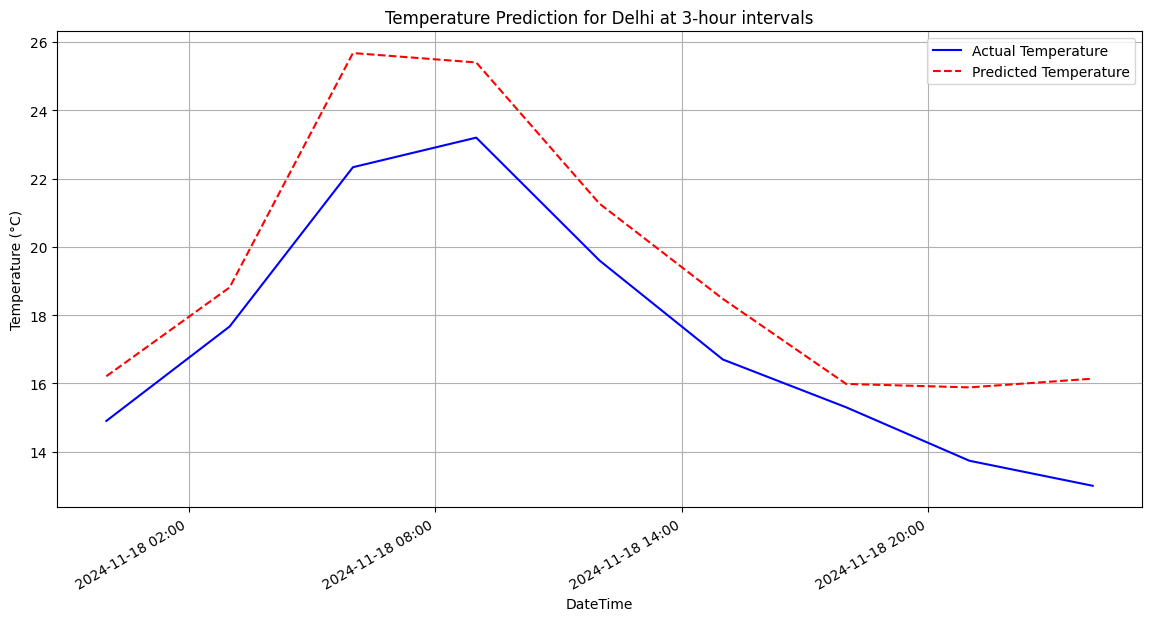

Predicted temperatures for 2024-11-19 at 3-hour intervals:
             DateTime  Predicted_Temperature
0 2024-11-19 00:00:00              16.138667
1 2024-11-19 03:00:00              16.666000
2 2024-11-19 06:00:00              20.803333
3 2024-11-19 09:00:00              21.804667
4 2024-11-19 12:00:00              18.929333
5 2024-11-19 15:00:00              17.283667
6 2024-11-19 18:00:00              17.004333
7 2024-11-19 21:00:00              15.969000


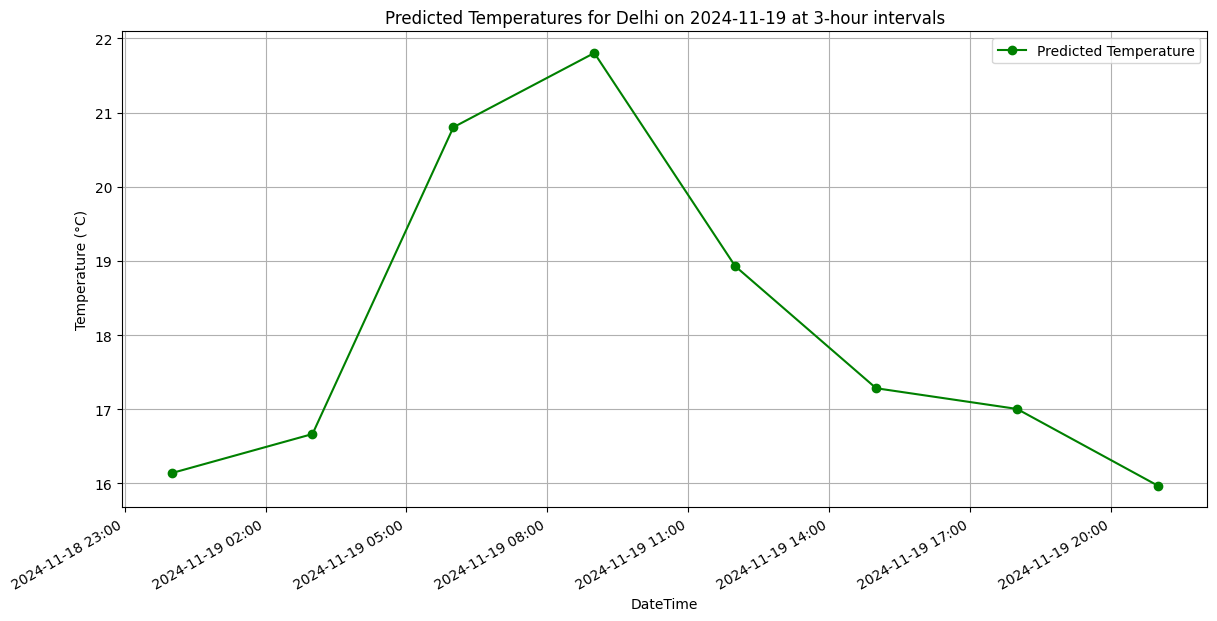

In [15]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from meteostat import Hourly, Stations
import matplotlib.dates as mdates
import pandas as pd

# Define the location (Delhi)
CITY = "Delhi"

# Coordinates for Delhi
latitude = 28.6139
longitude = 77.2090

# Get stations near Delhi
stations = Stations()
stations = stations.nearby(latitude, longitude)

# Fetch the nearest station
station = stations.fetch(1)

if station.empty:
    print("No station found for the specified city.")
else:
    # Define date range for the past 6 months
    end_date = datetime(2024, 11, 19)
    start_date = end_date - timedelta(days=180)

    # Fetch hourly data for the last 6 months
    print("Fetching historical hourly data...")
    data = Hourly(station.index[0], start_date, end_date)
    data = data.fetch()

    # Ensure data is not empty
    if data.empty:
        print("No data available for the specified date range.")
    else:
        # 1. Preprocess data
        data = data[['temp']].rename(columns={'temp': 'Temperature'})
        data.index.name = 'DateTime'

        # Resample data to 3-hour intervals
        data = data.resample('3H').mean()

        # Handle missing values
        data['Temperature'] = data['Temperature'].interpolate(method='time')
        data = data.dropna(subset=['Temperature'])

        # Reset index to make 'DateTime' a column
        data.reset_index(inplace=True)

        # 2. Prepare features
        def prepare_features(data, n_lags=8):
            """
            Create lag features for the dataset.
            """
            df = data.copy()
            for lag in range(1, n_lags + 1):
                df[f'Temperature_Lag_{lag}'] = df['Temperature'].shift(lag)
            df.dropna(inplace=True)
            return df

        # Use 8 lags (covering the past 24 hours)
        n_lags = 8
        data_prepared = prepare_features(data, n_lags=n_lags)

        # 3. Split data into training and testing sets
        # Use data up to 1 day before the end date for training
        train_end_time = end_date - timedelta(days=1)
        train_data = data_prepared[data_prepared['DateTime'] < train_end_time]
        test_data = data_prepared[data_prepared['DateTime'] >= train_end_time]

        X_train = train_data.drop(columns=['Temperature', 'DateTime'])
        y_train = train_data['Temperature']
        X_test = test_data.drop(columns=['Temperature', 'DateTime'])
        y_test = test_data['Temperature']

        # Check if training and testing data are not empty
        if X_train.empty or X_test.empty:
            print("Error: Training or testing data is empty. Please check the data fetching and preprocessing steps.")
        else:
            # 4. Train the Random Forest model
            print("Training the Random Forest model...")
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            # 5. Make predictions on the test set
            print("Making predictions...")
            y_pred = model.predict(X_test)

            # 6. Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

            # 7. Visualize results
            plt.figure(figsize=(14, 7))
            plt.plot(test_data['DateTime'], y_test, label="Actual Temperature", color='blue', linestyle='-')
            plt.plot(test_data['DateTime'], y_pred, label="Predicted Temperature", color='red', linestyle='--')
            plt.title(f"Temperature Prediction for {CITY} at 3-hour intervals")
            plt.xlabel("DateTime")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
            plt.gcf().autofmt_xdate()
            plt.show()

            # 8. Predict the temperature for the next day at 3-hour intervals
            future_times = pd.date_range(start=end_date, periods=8, freq='3H')
            predictions = []

            # Prepare the initial input data
            last_known_data = data_prepared.iloc[-1:].copy()

            for time in future_times:
                # Get the latest lag features
                input_features = last_known_data.drop(columns=['Temperature', 'DateTime'])
                # Predict the temperature
                pred_temp = model.predict(input_features)[0]
                predictions.append({'DateTime': time, 'Predicted_Temperature': pred_temp})

                # Update last_known_data for the next prediction
                new_row = pd.DataFrame({
                    'DateTime': [time],
                    'Temperature': [pred_temp]
                })

                # Shift lag features
                for lag in range(1, n_lags + 1):  # Include lag 8
                    if lag == 1:
                        new_row[f'Temperature_Lag_{lag}'] = last_known_data['Temperature'].values
                    else:
                        new_row[f'Temperature_Lag_{lag}'] = last_known_data[f'Temperature_Lag_{lag - 1}'].values

                last_known_data = new_row

            # Convert predictions to DataFrame
            predictions_df = pd.DataFrame(predictions)

            # Display predictions
            print(f"Predicted temperatures for {end_date.strftime('%Y-%m-%d')} at 3-hour intervals:")
            print(predictions_df)

            # Plot the predictions
            plt.figure(figsize=(14, 7))
            plt.plot(predictions_df['DateTime'], predictions_df['Predicted_Temperature'],
                     label="Predicted Temperature", color='green', marker='o')
            plt.title(f"Predicted Temperatures for {CITY} on {end_date.strftime('%Y-%m-%d')} at 3-hour intervals")
            plt.xlabel("DateTime")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
            plt.gcf().autofmt_xdate()
            plt.show()